In [19]:
examples_dir = '/home/mmn/repo/qpms-article/lepaper/figs/examples/' # prefix where the data is located

In [78]:
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge, hbar
from scipy.interpolate import griddata
eh = elementary_charge/hbar
import numpy as np
import os
import glob
import matplotlib
matplotlib.use('pdf')

D4h_irlabels = {"B2''":"$B_2''$",
                "B2'":"$B_2'$",
                "A1''":"$A_1''$",
                "A1'":"$A_1'$",
                "A2''":"$A_2''$",
                "B1''":"$B_1''$",
                "A2'":"$A_2'$", 
                "B1'":"$B_1'$",
                "E'":"$E'$",
                "E''":"$E''$",}



In [21]:
cd = os.path.join(examples_dir, "rectangular/scattering")
glob.glob(cd + '/*.npz')

['/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/cyl_r30nm_h30nm_p375nmx375nm_20x20_mAg_bg1.52_φ0π_θ(-0.025_0.025)π_ψ0.5π_χ0π_f2.15eV_L3.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/cyl_r30nm_h30nm_p375nmx375nm_mAg_bg1.52_φ0_θ(-0.0075_0.0075)π_ψ0π_χ0π_f2.11–2.23eV_L3.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/inf_big_px.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/cyl_r30nm_h30nm_p375nmx375nm_mAg_bg1.52_φ0_θ(-0.025_0.025)π_ψ0.5π_χ0π_f2.15eV_L3.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/cyl_r30nm_h30nm_p375nmx375nm_50x50_mAg_bg1.52_φ0π_θ(-0.025_0.025)π_ψ0.5π_χ0π_f2.15eV_L2.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/cyl_r30nm_h30nm_p375nmx375nm_40x40_mAg_bg1.52_φ0π_θ(-0.025_0.025)π_ψ0π_χ0π_f2.15eV_L2.npz',
 '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering

In [48]:
#f_finite_mesh =  '/home/mmn/repo/qpms-article/lepaper/figs/examples/rectangular/scattering/40x40_psi1.npz'
f_mesh_y = '/home/mmn/repo/qpms/examples/rectangular/scattering/inf.npz'
f_mesh_x = '/home/mmn/repo/qpms/examples/rectangular/scattering/inf_big_px.npz'
data_y = np.load(f_mesh_y)
data_x = np.load(f_mesh_x)
list(data_x.keys())

['meta',
 'dir_sph',
 'k_cart',
 'omega',
 'E_cart',
 'wavenumbers',
 'σ_ext',
 'σ_abs',
 'σ_scat',
 'unitcell_area']

In [107]:
sigmas = [[data_y[s], data_x[s]] for s in ['σ_scat','σ_abs','σ_ext']]
omegas = [data_y['omega'], data_x['omega']]
kxs = [data_y['k_cart'][:,:,0], data_x['k_cart'][:,:,0]]
# for colorbar range
#maxsigma = max(np.amax(sigmas[2][0]), np.amax(sigmas[2][1]))
#minsigma = min(min(np.amin(sigmas[l][0]), np.amin(sigmas[l][1])) for l in range(3))
maxsigma = max(np.quantile(sigmas[2][0], 0.999), np.quantile(sigmas[2][1], 0.999))
minsigma = min(min(np.quantile(sigmas[l][0], 0.001), np.quantile(sigmas[l][0], 0.001)) for l in range(3))
maxsigma, minsigma

# manual ranges
omegamin = 2.09 * eh
omegamax = 2.24 * eh
kmin = -0.6e6
kmax = 0.6e6

imshow_extent = (kmin / 1e6, kmax / 1e6, omegamin / eh, omegamax/eh) 
maxsigma, minsigma

(8.798339185764132e-14, 3.7485521428797764e-17)

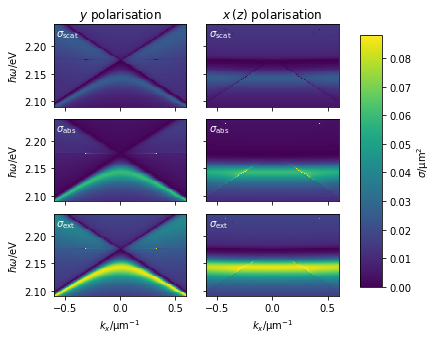

In [135]:
%matplotlib inline
ipm = "nearest" # interpolation method for griddata
f, ax = plt.subplots(3,2, figsize=(6,5))
#ax[0,0].set_title("TE")
#ax[0,1].set_title("TM")
ax[0,0].set_title("$y$ polarisation")
ax[0,1].set_title("$x\,(z)$ polarisation")
for l in (0,1):
    for c in (0,1):
        ax[l,c].tick_params(labelbottom=False)
for l in range(3):
    ax[l,1].tick_params(labelleft=False)


for c in (0,1):
    ax[2,c].set_xlabel('$k_x/\mathrm{\mu m^{-1}}$')
    
    om = omegas[c]
    dom = np.amin(np.diff(om)) / 2 # It should be equidistant, but...
    kx = kxs[c]
    dkx = np.amin(np.diff(kx)) / 2
    #grid_y, grid_x = np.mgrid[om[0]:om[-1]:dom, np.amax(kx[:,0]) : np.amin(kx[:,-1]) : dkx]
    grid_y, grid_x = np.mgrid[omegamin:omegamax:dom, kmin : kmax : dkx]
    
    # source points for griddata
    ompoints = np.broadcast_to(om[:,None], kx.shape)
    points = np.stack((kx.flatten(), ompoints.flatten()), axis=-1)
    
    for l in range(3):
        grid_z = griddata(points, sigmas[l][c].flatten(), (grid_x, grid_y), method=ipm) / 1e-12 # square micrometers
        im = ax[l,c].imshow(grid_z, origin='lower', vmin=0, vmax=maxsigma/1e-12, extent=imshow_extent,
                       aspect='auto', interpolation='none')
    
    # manual xticks, so they are the same as in the Beyn mode image
    #ax[l,c].set_xticks(np.arange(-0.6,0.7,0.2))
cax = f.add_axes([0.83, 0.15, 0.05, 0.7])
plt.subplots_adjust(right = 0.78, left=0.12, wspace=0.15, hspace=0.15)
cbar = f.colorbar(im, cax=cax)
cbar.set_label('$\sigma / \mathrm{\mu m^2}$')
        
    
    
    
    
for l, txt in enumerate(['$\\sigma_\\mathrm{scat}$','$\\sigma_\\mathrm{abs}$','$\\sigma_\\mathrm{ext}$']):
    for i in (0,1):
        ax[l,i].text(0.02, 0.95,txt,
           color='white',
           horizontalalignment='left',
           verticalalignment='top',
           transform = ax[l,i].transAxes)
    ax[l,0].set_ylabel('$\hbar\omega / \mathrm{eV}$')

plt.savefig("sqlat_inf_scatter.pdf")


In [85]:
kx.shape

(150, 201)

In [65]:
data_y['k_cart'].shape

(150, 201, 3)

In [76]:
np.diff(data_y['k_cart'][:,:,0])

array([[6045.26556378, 6045.35790435, 6045.44931265, ..., 6045.44931265,
        6045.35790435, 6045.26556378],
       [6050.13423404, 6050.22664897, 6050.31813089, ..., 6050.31813089,
        6050.22664897, 6050.13423404],
       [6055.00290429, 6055.09539359, 6055.18694913, ..., 6055.18694913,
        6055.09539359, 6055.00290429],
       ...,
       [6760.96009093, 6761.06336363, 6761.16559369, ..., 6761.16559369,
        6761.06336363, 6760.96009093],
       [6765.82876118, 6765.93210825, 6766.03441193, ..., 6766.03441193,
        6765.93210825, 6765.82876118],
       [6770.69743144, 6770.80085288, 6770.90323017, ..., 6770.90323017,
        6770.80085288, 6770.69743144]])

In [82]:
data_y['k_cart'][:,0,0]

array([-604832.84966793, -605319.96337236, -605807.07707679,
       -606294.19078123, -606781.30448566, -607268.41819009,
       -607755.53189452, -608242.64559895, -608729.75930338,
       -609216.87300781, -609703.98671224, -610191.10041667,
       -610678.2141211 , -611165.32782553, -611652.44152996,
       -612139.55523439, -612626.66893882, -613113.78264325,
       -613600.89634768, -614088.01005211, -614575.12375654,
       -615062.23746098, -615549.35116541, -616036.46486984,
       -616523.57857427, -617010.6922787 , -617497.80598313,
       -617984.91968756, -618472.03339199, -618959.14709642,
       -619446.26080085, -619933.37450528, -620420.48820971,
       -620907.60191414, -621394.71561857, -621881.829323  ,
       -622368.94302743, -622856.05673186, -623343.17043629,
       -623830.28414073, -624317.39784516, -624804.51154959,
       -625291.62525402, -625778.73895845, -626265.85266288,
       -626752.96636731, -627240.08007174, -627727.19377617,
       -628214.3074806 ,

In [79]:
omegas[0].shape

(150,)

In [114]:
import os
os.getcwd()

'/home/mmn'